In [1]:
import torch
import matplotlib.pyplot as plt
from src.model import VAE
import os
from src.utils import calculate_statistics, visualize_reconstruction, denormalize, interpolate_tiles
from src.data_processing import BrainTileDataset, DensityBasedSampler
import torch
from torch.utils.data import DataLoader

In [2]:
# Find the best model path dynamically
test_set = 'B20' # Change this to the test set you want to evaluate
checkpoint_dir = os.path.join(os.getcwd(), 'checkpoints')
if test_set is None:
    best_model_path = [f for f in os.listdir(checkpoint_dir)][0]
    best_model_path = os.path.join(checkpoint_dir, best_model_path)
    test_set = best_model_path.split('-')[-2]
    latent_dim = int(best_model_path.split('-')[-1].split('.')[0])
else:
    best_model_path = [f for f in os.listdir(checkpoint_dir) if test_set in f][0]
    best_model_path = os.path.join(checkpoint_dir, best_model_path)
    latent_dim = int(best_model_path.split('-')[-1].split('.')[0])

In [21]:
num_downsamples = int(torch.log2(torch.tensor(64))) - 2  # Stop when spatial size reaches
base_channels = 2 ** num_downsamples
[32 * (2 ** i) for i in range(num_downsamples)]

[32, 64, 128, 256]

In [3]:
data_path = 'cell_data.h5'
global_stats = calculate_statistics(data_path, test_set=test_set)
global_mean = global_stats['mean']
global_std = global_stats['std']

Loading cached statistics for test set B20...


In [4]:
# Load the best checkpoint and initialize the model with saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(latent_dim=latent_dim)
model = VAE.load_from_checkpoint(best_model_path, map_location=device)
model.eval()

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

**(a) Latent Space Sampling and Decoding**

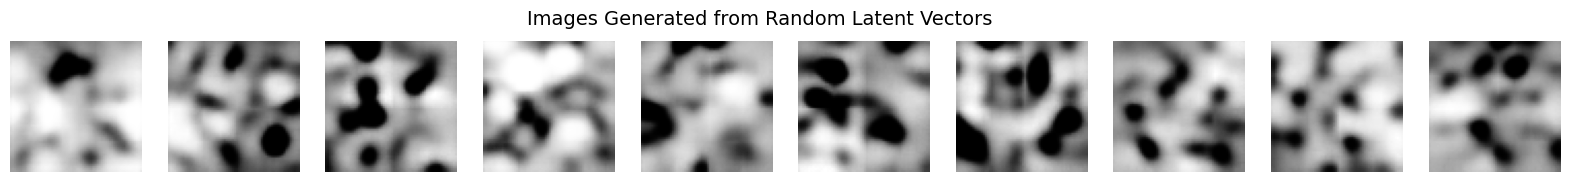

In [5]:
# Sample 10 random latent vectors from a standard Gaussian distribution
latent_vectors = torch.randn(10, model.latent_dim).to(device)

# Decode the latent vectors to generate images
with torch.no_grad():
    generated_images = model.decoder(latent_vectors)

# Visualize the generated images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(denormalize(generated_images[i].permute(1, 2, 0).cpu().numpy(), global_mean, global_std), cmap='gray')
    ax.axis('off')
plt.suptitle("Images Generated from Random Latent Vectors", fontsize=14)
plt.show()

**(b) Interpolation in Latent Space**

In [6]:
test_dataset = BrainTileDataset(data_path, global_stats, test_set=test_set, tile_size=64, testing=True, metadata=True)
random_sampler = DensityBasedSampler(test_dataset, samples_per_epoch=1024, density=True)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=64,
    sampler=random_sampler,
    shuffle=False,
)

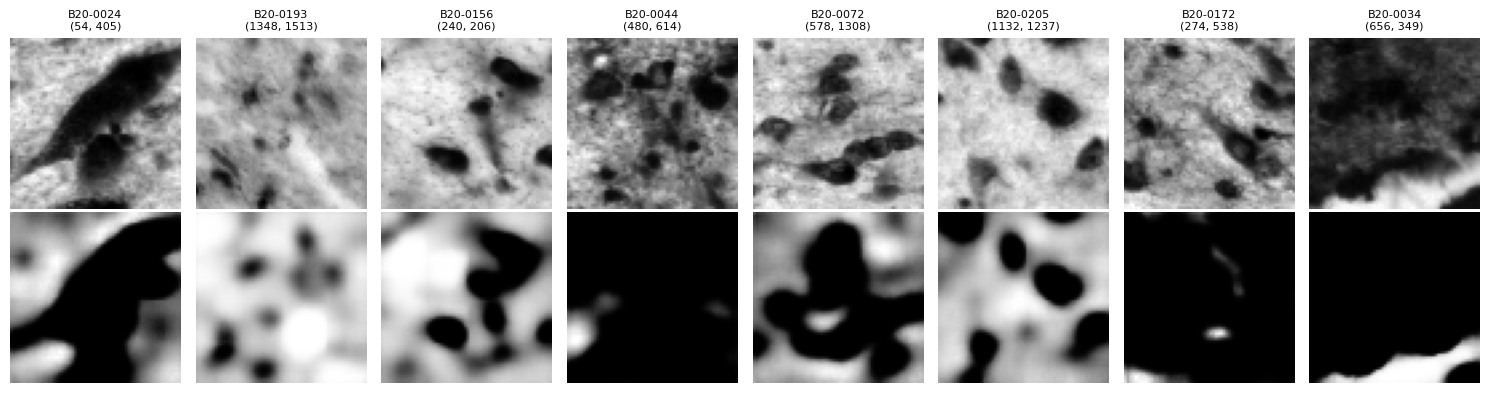

In [7]:
sample_batch, metadata = next(iter(test_dataloader))
sample_batch = sample_batch.to(device)
reconstructed, _, _ = model(sample_batch)
reconstructed_denormalized = denormalize(reconstructed.cpu(), global_mean, global_std)
visualize_reconstruction(sample_batch.cpu(), reconstructed_denormalized, metadata)
plt.show()

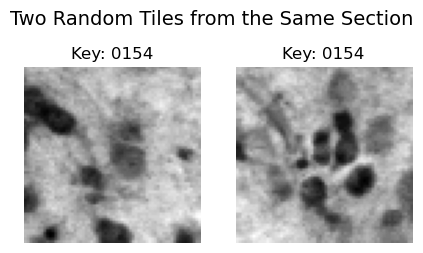

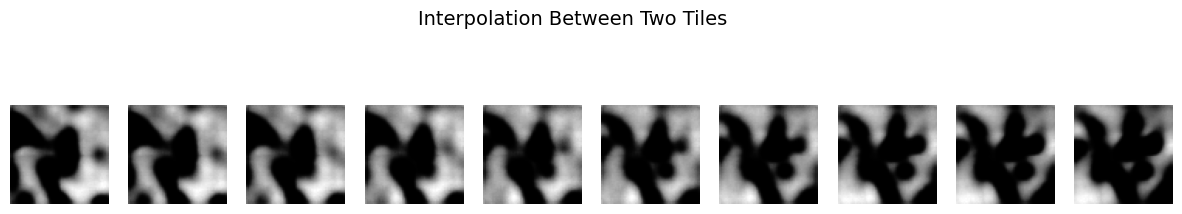

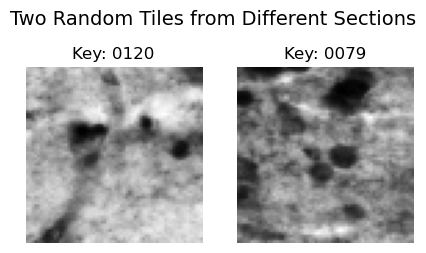

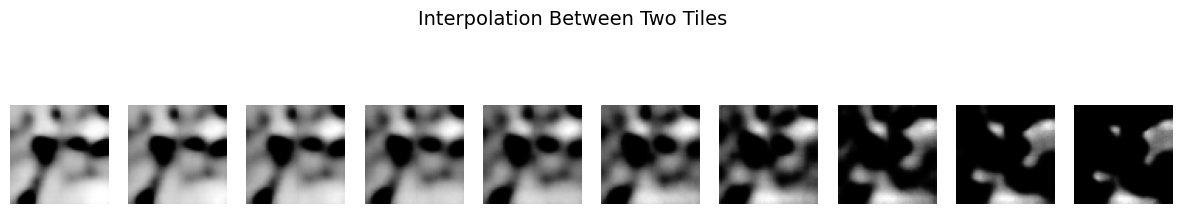

In [8]:
# Interpolate between two random samples
interpolate_tiles(model, sample_batch, metadata, global_mean, global_std, same_section=True)
interpolate_tiles(model, sample_batch, metadata, global_mean, global_std, same_section=False)

**(c) Latent Space Visualization**

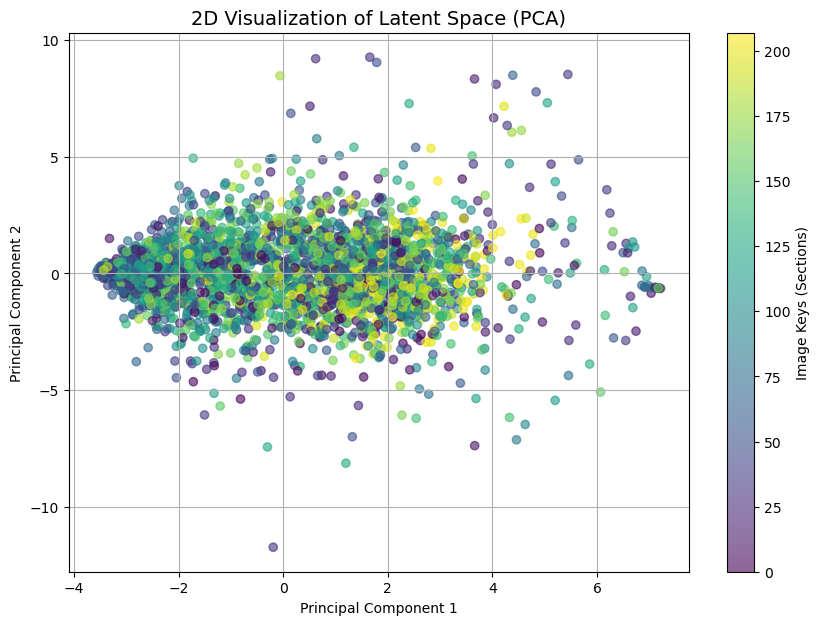

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Sample 3000 tiles from the test dataset
num_tiles = 3000
sample_tiles = []
image_keys = []

while len(sample_tiles) < num_tiles:
    batch, metadata = next(iter(test_dataloader))
    sample_tiles.append(batch)
    image_keys.extend(metadata[1])
    if len(sample_tiles) * batch.size(0) >= num_tiles:
        break

sample_tiles = torch.cat(sample_tiles)[:num_tiles].to(device)
image_keys = image_keys[:num_tiles]

# Encode tiles into latent representations
latent_representations, _ = model.encoder(sample_tiles)

# Convert image_keys to numerical labels
label_encoder = LabelEncoder()
image_keys_numeric = label_encoder.fit_transform(image_keys)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
reduced_latents = pca.fit_transform(latent_representations.detach().cpu().numpy())

# Plot the 2D latent space with image_keys as labels
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_latents[:, 0], reduced_latents[:, 1], c=image_keys_numeric, alpha=0.6, cmap='viridis')
plt.title("2D Visualization of Latent Space (PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Image Keys (Sections)')
plt.grid(True)

# Annotate each point with its label
# for i, key in enumerate(image_keys):
#     plt.text(reduced_latents[i, 0], reduced_latents[i, 1], key, fontsize=8, ha='right')

plt.show()

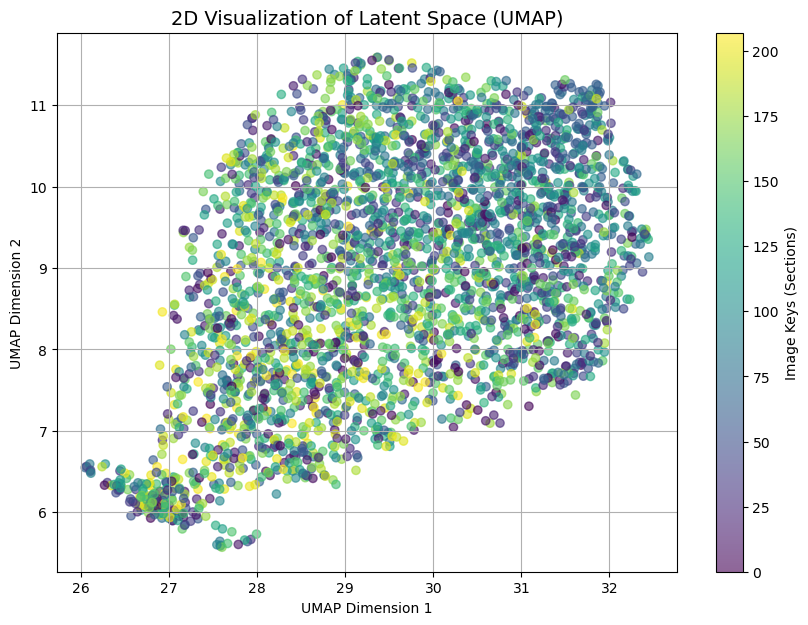

In [10]:
import umap

# Reduce dimensionality using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
reduced_latents_umap = reducer.fit_transform(latent_representations.detach().cpu().numpy())

# Convert image_keys to numerical labels if not already done
if not isinstance(image_keys[0], int):
    image_keys_numeric = label_encoder.fit_transform(image_keys)

# Plot the 2D latent space
plt.figure(figsize=(10, 7))
scatter = plt.scatter(x=reduced_latents_umap[:, 0], y=reduced_latents_umap[:, 1], c=image_keys_numeric, alpha=0.6, cmap='viridis')
plt.title("2D Visualization of Latent Space (UMAP)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label='Image Keys (Sections)')
plt.grid(True)
plt.show()